In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import random
from imblearn.over_sampling import SMOTENC

In [26]:
train = pd.read_csv('train.csv', index_col = 0)
test = pd.read_csv('test.csv', index_col = 0)
full_data = pd.read_csv('cleaned_data/diabetes_cleaned.csv', index_col = 0)

In [27]:
from sklearn.metrics import roc_curve, auc

def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    pred_values = model.predict(data)
    bins=np.array([0,cutoff,1])
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

#### SMOTENC: Used to balance the distribution of responses in readmitted

In [28]:
X_train = train.drop(columns="readmitted")
y_train = train.loc[:, "readmitted"]

X_train_types = X_train.dtypes.to_frame().rename(columns={0: "type"})
# get the name of all variables that are objects
object_vars = list(X_train_types.loc[X_train_types.type == "object", :].index)
object_vars = object_vars + ["age", "admission_type_id", "discharge_disposition_id", "admission_source_id", "time_in_hospital", "num_of_changes"]

# get the indices of all 
object_var_indices = []
for i in range(0, len(X_train.columns)):
    if X_train.columns[i] in object_vars:
        object_var_indices.append(i)

In [29]:
smote_nc = SMOTENC(categorical_features=object_var_indices, random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [30]:
# add the readmitted data back in
X_resampled.loc[:, "readmitted"] = y_resampled
train1 = X_resampled.copy()

In [31]:
dummy_preds = ["age", "time_in_hospital", "admission_type_id", "discharge_disposition_id", "admission_source_id", 
               "diag_1", "diag_2", 'diabetesMed','change']
train1_dummy = train1.copy()
test_dummy = test.copy()
vars = []

for pred in dummy_preds:
    dummy_train = pd.get_dummies(train1.loc[:, pred])
    dummy_train.columns = [pred + str(x) for x in dummy_train.columns]
    train1_dummy = pd.concat([train1_dummy, dummy_train], axis=1)
    vars.append(list(dummy_train.columns))
    
    dummy_test = pd.get_dummies(test.loc[:, pred])
    dummy_test.columns = [pred + str(x) for x in dummy_test.columns]
    test_dummy = pd.concat([test_dummy, dummy_test], axis=1)

### Single best model from Amy's model optimization

In [32]:
modified_form = 'readmitted ~ age + diag_1circulatory + diag_1diabetes + diag_1digestive + diag_1injury + diag_1musculoskeletal + diag_1neoplasms + diag_1other + diag_1pregnecy + time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + discharge_disposition_id7 + discharge_disposition_id18 + admission_type_id1 + admission_type_id3 + num_of_changes + number_inpatient + diag_2circulatory + diag_2diabetes + diag_2digestive + diag_2injury + diag_2musculoskeletal + diag_2other'
modified_form

'readmitted ~ age + diag_1circulatory + diag_1diabetes + diag_1digestive + diag_1injury + diag_1musculoskeletal + diag_1neoplasms + diag_1other + diag_1pregnecy + time_in_hospital1 + time_in_hospital2 + time_in_hospital3 + time_in_hospital4 + time_in_hospital5 + time_in_hospital6 + time_in_hospital7 + time_in_hospital8 + time_in_hospital9 + time_in_hospital10 + time_in_hospital11 + time_in_hospital12 + time_in_hospital13 + discharge_disposition_id7 + discharge_disposition_id18 + admission_type_id1 + admission_type_id3 + num_of_changes + number_inpatient + diag_2circulatory + diag_2diabetes + diag_2digestive + diag_2injury + diag_2musculoskeletal + diag_2other'

In [33]:
single_model = sm.logit(formula = modified_form,
 data = train1_dummy).fit() 
single_model.summary()

Optimization terminated successfully.
         Current function value: 0.631324
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104429
Method:                           MLE   Df Model:                           34
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                 0.08919
Time:                        20:38:12   Log-Likelihood:                -65951.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -3.1085      0.092    -33.627      0.000      -3.290      -2.927
age                            0.0184      0.000     38.047      0.000       0.017       0.019
diag_1circulatory              0.8720      0.020     43.190      0.000       0.832       0.912
diag_1diabetes                 0.3139      0.031     10.206      0.000       0.254       0.374
diag_1digestive                0.0804      0.029      2.737      0.006       0.023       0.138
diag_1injury                   0.4394      0.031     14.228      0.000       0.379       0.500
diag_1musculoskeletal          0.3534      0.036      9.724      0.000       0.282       0.425
diag_1neoplasms                0.2721      0.043      6.324      0.000       0.188       0.356
diag_1other                    0.5343      0.023     22.970      0.000       0.489       0.580
diag_1pregnecy                -0.2916      0.141     -2.074      0.038      -0.567      -0.016
time_in_hospital1              0.3126      0.081      3.861      0.000       0.154       0.471
time_in_hospital2              0.5690      0.080      7.073      0.000       0.411       0.727
time_in_hospital3              0.6815      0.080      8.485      0.000       0.524       0.839
time_in_hospital4              0.7355      0.081      9.112      0.000       0.577       0.894
time_in_hospital5              0.6525      0.082      8.004      0.000       0.493       0.812
time_in_hospital6              0.8142      0.082      9.910      0.000       0.653       0.975
time_in_hospital7              0.7034      0.083      8.439      0.000       0.540       0.867
time_in_hospital8              0.8266      0.085      9.728      0.000       0.660       0.993
time_in_hospital9              0.4588      0.089      5.163      0.000       0.285       0.633
time_in_hospital10             0.6853      0.091      7.539      0.000       0.507       0.863
time_in_hospital11             0.3065      0.096      3.198      0.001       0.119       0.494
time_in_hospital12             0.5064      0.099      5.110      0.000       0.312       0.701
time_in_hospital13             0.2315      0.106      2.186      0.029       0.024       0.439
discharge_disposition_id7     -1.7894      0.179     -9.994      0.000      -2.140      -1.439
discharge_disposition_id18     0.2548      0.031      8.285      0.000       0.195       0.315
admission_type_id1             0.4799      0.022     21.354      0.000       0.436       0.524
admission_type_id3            -0.4548      0.028    -16.076      0.000      -0.510      -0.399
num_of_changes                -0.4981      0.016    -31.039      0.000      -0.530      -0.467
number_inpatient               0.1586      0.011     14.835      0.000       0.138       0.180
diag_2circulatory              0.6848      0.020     34.342      0.000       0.646       0.724
diag_2diabetes                 0.4601      0.025     18.273      0.000       0.411       0.509
diag_2diges

Classification accuracy = 64.2%
Precision = 63.4%
TPR or Recall = 67.3%
FNR = 32.7%
FPR = 38.8%
ROC-AUC = 69.5%


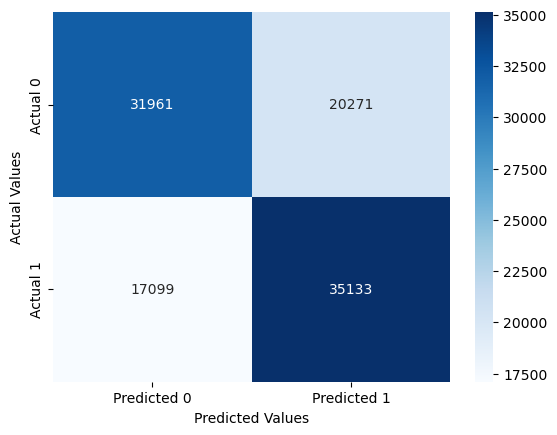

In [34]:
confusion_matrix_data(train1_dummy, train1_dummy.readmitted, single_model, cutoff=0.5)

Classification accuracy = 59.6%
Precision = 10.3%
TPR or Recall = 44.2%
FNR = 55.8%
FPR = 38.9%
ROC-AUC = 54.0%


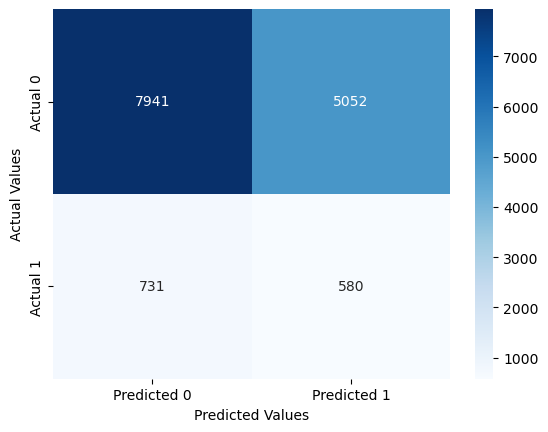

In [35]:
confusion_matrix_data(test_dummy, test_dummy.readmitted, single_model, cutoff=0.5)

### Attempting feature selection using SkLearn

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
# getting a list of the all the usable numerical predictors
preds = train1_dummy.dtypes[train1_dummy.dtypes != object].index.tolist()
# dropping the unusable and duplicate numeric predictors
preds.remove('age')
preds.remove('time_in_hospital')
preds.remove('admission_type_id')
preds.remove('discharge_disposition_id')
preds.remove('admission_source_id')
preds.remove('encounter_id')
preds.remove('patient_nbr')
preds.remove('discharge_disposition_id27')
preds.remove('readmitted')

In [38]:
# creating the features and the response for skLearn
sk_X = train1_dummy[preds]
sk_y = train1_dummy.readmitted

In [39]:
# creating the penalized model and fit
log = LogisticRegression(penalty='l1', solver='liblinear')
log.fit(sk_X,sk_y)

LogisticRegression(penalty='l1', solver='liblinear')

In [40]:
# getting a list of significant predictors 
# whose coefficient is not zero
coefs = log.coef_
sig_preds = np.array(preds)[np.where(coefs != 0)[1]]

Classification accuracy = 69.9%
Precision = 68.7%
TPR or Recall = 73.0%
FNR = 27.0%
FPR = 33.3%
ROC-AUC = 69.9%


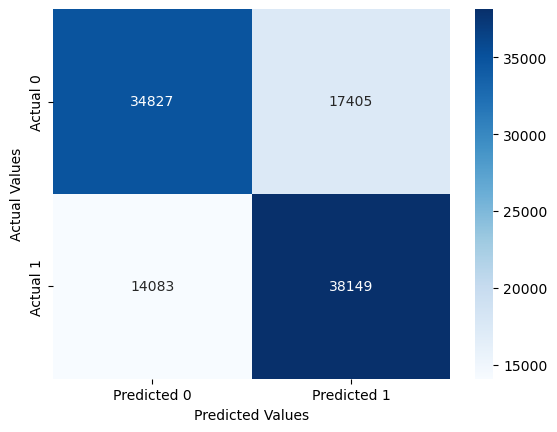

In [41]:
confusion_matrix_data(train1_dummy[preds], train1_dummy.readmitted,log,cutoff=0.5)


Classification accuracy = 64.5%
Precision = 11.3%
TPR or Recall = 41.6%
FNR = 58.4%
FPR = 33.1%
ROC-AUC = 54.3%


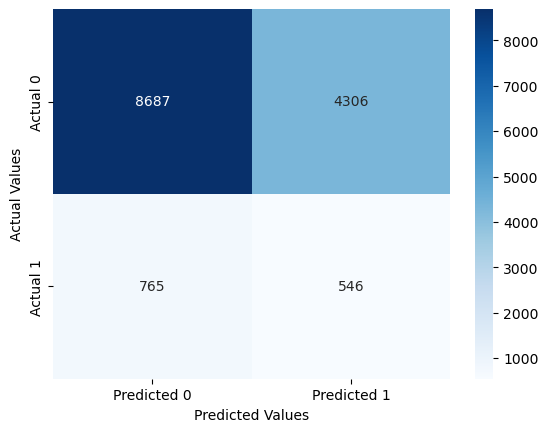

In [42]:
confusion_matrix_data(test_dummy[preds], test_dummy.readmitted,log,cutoff=0.5)

### Attempting Interaction Variables

### Variable interactions to test out:
- change * diabetesMed
- age * time_in_hospital
- age * number_inpatient
- change * admission_source_id

Without using the significant predictors from the previous model

In [43]:
model = sm.logit(formula = "readmitted~age*time_in_hospital+age*number_inpatient+num_lab_procedures+num_procedures+num_medications+number_outpatient+number_emergency+number_diagnoses+num_of_changes+ diabetesMed+diag_1+diag_2", data = train1).fit_regularized()
model.summary()


/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6063380231594818
            Iterations: 178
            Function evaluations: 191
            Gradient evaluations: 178


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:               104464
Model:                          Logit   Df Residuals:                   104432
Method:                           MLE   Df Model:                           31
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                  0.1252
Time:                        20:38:39   Log-Likelihood:                -63340.
converged:                       True   LL-Null:                       -72409.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -2.3565      0.069    -34.050      0.000      -2.492      -2.221
diabetesMed[T.Yes]            1.3953      0.020     68.876      0.000       1.356       1.435
diag_1[T.diabetes]           -0.6409      0.029    -22.150      0.000      -0.698      -0.584
diag_1[T.digestive]          -0.6949      0.027    -25.317      0.000      -0.749      -0.641
diag_1[T.genitourinary]      -0.8842      0.036    -24.360      0.000      -0.955      -0.813
diag_1[T.injury]             -0.4343      0.029    -15.017      0.000      -0.491      -0.378
diag_1[T.musculoskeletal]    -0.8402      0.034    -24.766      0.000      -0.907      -0.774
diag_1[T.neoplasms]          -0.7032      0.043    -16.493      0.000      -0.787      -0.620
diag_1[T.other]              -0.4095      0.020    -20.204      0.000      -0.449      -0.370
diag_1[T.pregnecy]           -0.9175      0.171     -5.375      0.000      -1.252      -0.583
diag_1[T.respiratory]        -0.9612      0.023    -41.207      0.000      -1.007      -0.916
diag_2[T.diabetes]           -0.3093      0.023    -13.611      0.000      -0.354      -0.265
diag_2[T.digestive]          -0.6943      0.044    -15.920      0.000      -0.780      -0.609
diag_2[T.genitourinary]      -0.6962      0.030    -23.260      0.000      -0.755      -0.638
diag_2[T.injury]             -0.8637      0.053    -16.253      0.000      -0.968      -0.760
diag_2[T.musculoskeletal]    -1.2010      0.073    -16.507      0.000      -1.344      -1.058
diag_2[T.neoplasms]          -0.6313      0.053    -11.897      0.000      -0.735      -0.527
diag_2[T.other]              -0.0376      0.018     -2.132      0.033      -0.072      -0.003
diag_2[T.pregnecy]           -1.1315      0.256     -4.415      0.000      -1.634      -0.629
diag_2[T.respiratory]        -0.7085      0.026    -26.962      0.000      -0.760      -0.657
age                           0.0280      0.001     31.356      0.000       0.026       0.030
time_in_hospital              0.1592      0.012     12.896      0.000       0.135       0.183
age:time_in_hospital         -0.0022      0.000    -12.787      0.000      -0.003      -0.002
number_inpatient              0.2861      0.050      5.701      0.000       0.188       0.384
age:number_inpatient         -0.0022      0.001     -2.989      0.003      -0.004      -0.001
num_lab_procedures            0.0039      0.000      9.976      0.000       0.003       0.005
num_procedures               -0.2151      0.005    -44.033      0.000      -0.225      -0.206
num_medications               0.0213      0.001     19.614      0.000       0.019       0.023
number_outpatient            -0.1108      0.008    -13.481      0.000      -0.127      -0.095
number_emergency             -0.1169      0.017     -6.803      0.000      -0.151      -0.083
number_diagnoses             -0.0280      0.004     -7.001      0.000      -0.036      -0.020
num_of_changes               -0.7966      0.0

Classification accuracy = 67.5%
Precision = 66.4%
TPR or Recall = 70.7%
FNR = 29.3%
FPR = 35.8%
ROC-AUC = 73.3%


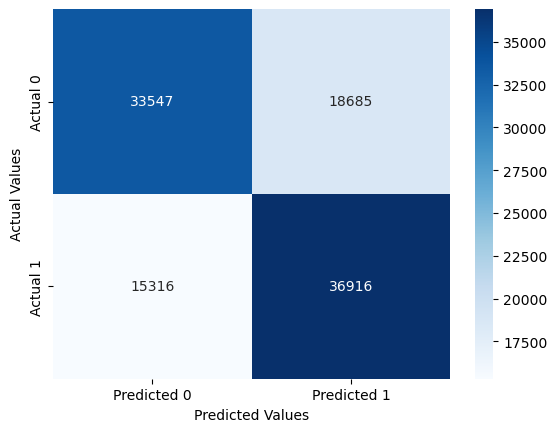

In [44]:
confusion_matrix_data(train1, train1.readmitted, model, cutoff=0.5)


Classification accuracy = 62.3%
Precision = 10.9%
TPR or Recall = 43.4%
FNR = 56.6%
FPR = 35.8%
ROC-AUC = 55.2%


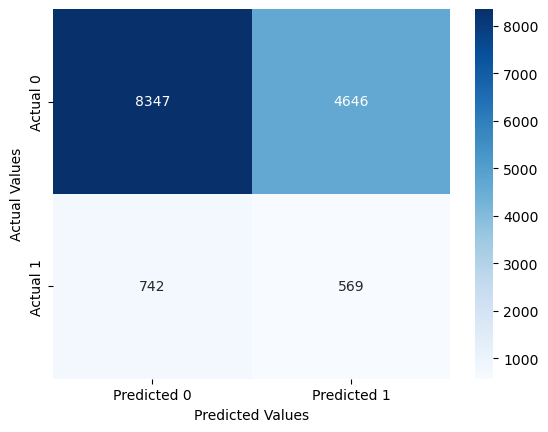

In [45]:
confusion_matrix_data(test, test.readmitted, model, cutoff=0.5)

### Reattempt using SkLearn w/ significant predictors

In [21]:
from patsy import dmatrices

In [22]:
# remove repeated predictors
sig_preds.remove('diabetesMedNo')
sig_preds.remove('diabetesMedYes')
sig_preds.remove('changeCh')
sig_preds.remove('changeNo')

AttributeError: 'numpy.ndarray' object has no attribute 'remove'

In [23]:
# creating the formula
f = 'num_lab_procedures'
for i in sig_preds[1:]:
    f = f + '+' + i

In [24]:
# adding interations on to the formula
f1 = f+'+change*diabetesMed+(age5+age15+age25+age35+age45+age55+age65+age75+age85+age95)*(time_in_hospital1+time_in_hospital2+time_in_hospital3+time_in_hospital4+time_in_hospital5+time_in_hospital6+time_in_hospital7+time_in_hospital8+time_in_hospital9+time_in_hospital10+time_in_hospital11+time_in_hospital12+time_in_hospital13+time_in_hospital14)+(age5+age15+age25+age35+age45+age55+age65+age75+age85+age95)*number_inpatient+change*(admission_type_id1+admission_type_id3+admission_type_id4+admission_type_id5)'

In [57]:
# creating features for sklearn w/ interactions using patsy
# test data
y0,X0 = dmatrices("readmitted~"+f1, train1_dummy)

In [61]:
# same thing here for train data
y1,X1 =  dmatrices("readmitted~"+f1, test_dummy) 

In [20]:
# fit the logistic model
log.fit(X0,y0)

NameError: name 'X0' is not defined

In [86]:
# get the name of the predictors
coef_names = X0.design_info.column_names

In [84]:
# get the list of coeffceints
coefs0 = log.coef_

In [90]:
# find the list of the predictors
# whose coefficient is non zero
sig_preds0 = np.array(coef_names)[np.where(coefs0 != 0)[1]]

In [91]:
# Here's the list of the coefficient
sig_preds0

array(['Intercept', 'change[T.No]', 'diabetesMed[T.Yes]',
       'change[T.No]:diabetesMed[T.Yes]', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'num_of_changes', 'age5', 'age15', 'age25', 'age35', 'age45',
       'age55', 'age65', 'age75', 'age85', 'age95', 'time_in_hospital1',
       'time_in_hospital2', 'time_in_hospital3', 'time_in_hospital4',
       'time_in_hospital6', 'time_in_hospital7', 'time_in_hospital8',
       'time_in_hospital9', 'time_in_hospital10', 'time_in_hospital11',
       'time_in_hospital13', 'time_in_hospital14', 'admission_type_id1',
       'change[T.No]:admission_type_id1', 'admission_type_id3',
       'change[T.No]:admission_type_id3', 'admission_type_id4',
       'admission_type_id5', 'change[T.No]:admission_type_id5',
       'discharge_disposition_id1', 'discharge_disposition_id2',
       'discharge_disposition_id7', 'discharge_disposition_id1

In [96]:
# list of the coefficients
np.array(coefs0)[np.where(coefs0 != 0)]

array([-4.17440643e-01, -8.51821069e-01,  4.71926018e-01,  9.13960765e-01,
        6.44495657e-04, -1.84820685e-01,  2.69327885e-02, -1.07848361e-01,
       -1.23226215e-01,  1.56929478e-01, -6.05683669e-02, -7.57656501e-01,
       -3.37464970e+00, -1.03343450e+00, -8.39458653e-01, -2.01851248e-01,
       -6.14924751e-02,  7.40811343e-02,  4.48549378e-01,  6.44613151e-01,
        4.22413965e-01, -5.11174083e-01, -1.63996151e-01, -2.08826200e-02,
       -1.44266479e-02,  4.84216021e-02,  1.66368193e-01,  8.00848735e-02,
        3.41132840e-01, -1.06793876e-01,  1.90621010e-02, -3.06359737e-01,
       -3.77009704e-01, -7.98516858e-01,  7.25294200e-02,  2.75797777e-02,
       -7.29917739e-01, -7.03716794e-02, -2.26669555e-01, -4.30015895e-01,
       -2.92286759e-02, -3.53107118e-02,  1.66183909e-01, -1.76030070e+00,
       -3.02674849e-01, -6.67816186e+00,  3.70357708e-01, -8.91888632e-02,
       -8.24968280e-01,  3.77812095e-02, -1.36546503e+00, -9.62247709e-02,
        5.94855514e-01, -

Classification accuracy = 69.9%
Precision = 68.7%
TPR or Recall = 73.2%
FNR = 26.8%
FPR = 33.4%
ROC-AUC = 69.9%


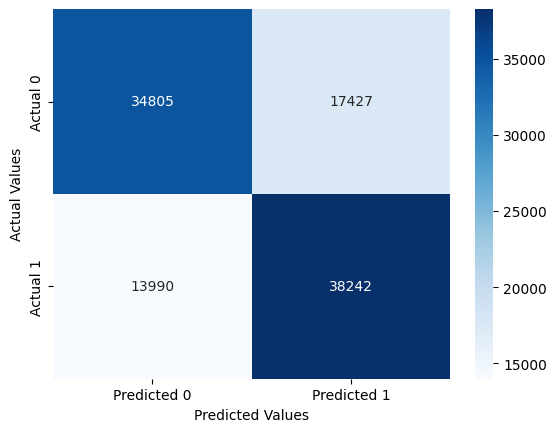

In [71]:
# Test Data Metrics
confusion_matrix_data(np.asarray(X0), train1_dummy.readmitted, log, cutoff=0.5)

Classification accuracy = 64.6%
Precision = 11.3%
TPR or Recall = 41.9%
FNR = 58.1%
FPR = 33.1%
ROC-AUC = 54.4%


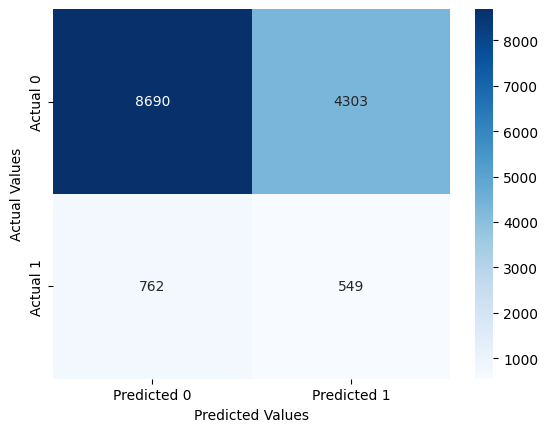

In [72]:
# Test Data Accuracy
confusion_matrix_data(np.asarray(X1), test_dummy.readmitted, log, cutoff=0.5)